# Picture Draw

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Loading VGGDepth prediction

In [ ]:
import scipy.io as io
import numpy as np

## Single station testing data loading
test_result_CESI = scipy.io.loadmat('./logs_fortest/test/Depth_Single_station_CESO_lr0.0001_batch100/test_result.mat')['test_result']


## SNR Loading 

In [ ]:
## SNR

snr_array = io.loadmat('./SNR/snr_array_17-4.mat')['snr_array']


## Accuracy depth

In [9]:
label_xyz = scipy.io.loadmat('./label_xyz_17-4')['label_xyz']

In [5]:
def read_cat_txt(filepath):
    data = []
    with open(filepath, 'r') as file:
        for line in file:
            if line.strip():  # 确保不读取空行
                parts = line.split()  # 默认以空格分割，你也可以根据实际情况修改分隔符
                if len(parts) >= 10:
                    record = {
                        'year': int(parts[0]),
                        'month': int(parts[1]),
                        'day': int(parts[2]),
                        'hour': int(parts[3]),
                        'minute': int(parts[4]),
                        'second': float(parts[5]),
                        'latitude': float(parts[6]),
                        'longitude': float(parts[7]),
                        'depth': float(parts[8]),
                        'EH1': float(parts[9]),
                        'EH2': float(parts[10]),
                        'AZ': float(parts[11]),
                        'EZ': float(parts[12]),        
                        'magnitude1': float(parts[13]),
                        'magnitude2': float(parts[14]),
                        'ID': int(parts[15])
                    }
                    data.append(record)
                else:
                    print(f"Ignoring line: {line.strip()}")  # 可选：处理格式不正确的行

    return data

# 用法示例
filepath = './Amatrice_catalog_2017-4-31_maked.txt'  # 替换为你的文件路径
events_cat = read_cat_txt(filepath)

In [6]:
from datetime import datetime, timezone
# 提取事件时间信息
events_time=([[int(i['year']),int(i['month']),int(i['day']),int(i['hour']),int(i['minute']),int(i['second'])] for i in events_cat])



# 用于存储转换后的UTC时间字符串
events_utc_times = []


# # 遍历事件列表
for event_time in events_time:
    # 解包事件时间信息
    year, month, day, hour, minute, second = event_time
    
    # 构建本地时间对象
    local_time = datetime(year, month, day, hour, minute, second)
    #print(local_time)
    # 转换为UTC时间
    # events_utc = local_time.astimezone(timezone.utc)
    # print(events_utc)
    # 格式化为字符串，符合ISO 8601格式，带毫秒和时区Z
    utc_str = local_time.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
    
    # 将格式化后的UTC时间字符串存入列表
    events_utc_times.append(utc_str)

# 打印转换后的UTC时间字符串列表
for utc_str in events_utc_times:
    print(utc_str)

2017-04-01T00:06:57.000000Z
2017-04-01T00:19:30.000000Z
2017-04-01T00:24:16.000000Z
2017-04-01T00:35:59.000000Z
2017-04-01T00:41:29.000000Z
2017-04-01T00:43:24.000000Z
2017-04-01T00:45:46.000000Z
2017-04-01T00:46:36.000000Z
2017-04-01T01:00:50.000000Z
2017-04-01T01:07:09.000000Z
2017-04-01T01:15:50.000000Z
2017-04-01T01:15:52.000000Z
2017-04-01T01:23:39.000000Z
2017-04-01T01:28:03.000000Z
2017-04-01T01:37:50.000000Z
2017-04-01T01:38:46.000000Z
2017-04-01T01:42:06.000000Z
2017-04-01T01:42:06.000000Z
2017-04-01T01:42:43.000000Z
2017-04-01T01:49:38.000000Z
2017-04-01T01:59:58.000000Z
2017-04-01T02:00:37.000000Z
2017-04-01T02:02:37.000000Z
2017-04-01T02:03:57.000000Z
2017-04-01T02:07:55.000000Z
2017-04-01T02:10:56.000000Z
2017-04-01T02:22:24.000000Z
2017-04-01T02:22:55.000000Z
2017-04-01T02:28:43.000000Z
2017-04-01T02:28:44.000000Z
2017-04-01T02:35:55.000000Z
2017-04-01T02:36:24.000000Z
2017-04-01T02:37:04.000000Z
2017-04-01T02:42:29.000000Z
2017-04-01T03:02:43.000000Z
2017-04-01T03:07:16.

In [7]:
label_magnitude=np.array([[float(i['magnitude2'])] for i in events_cat])

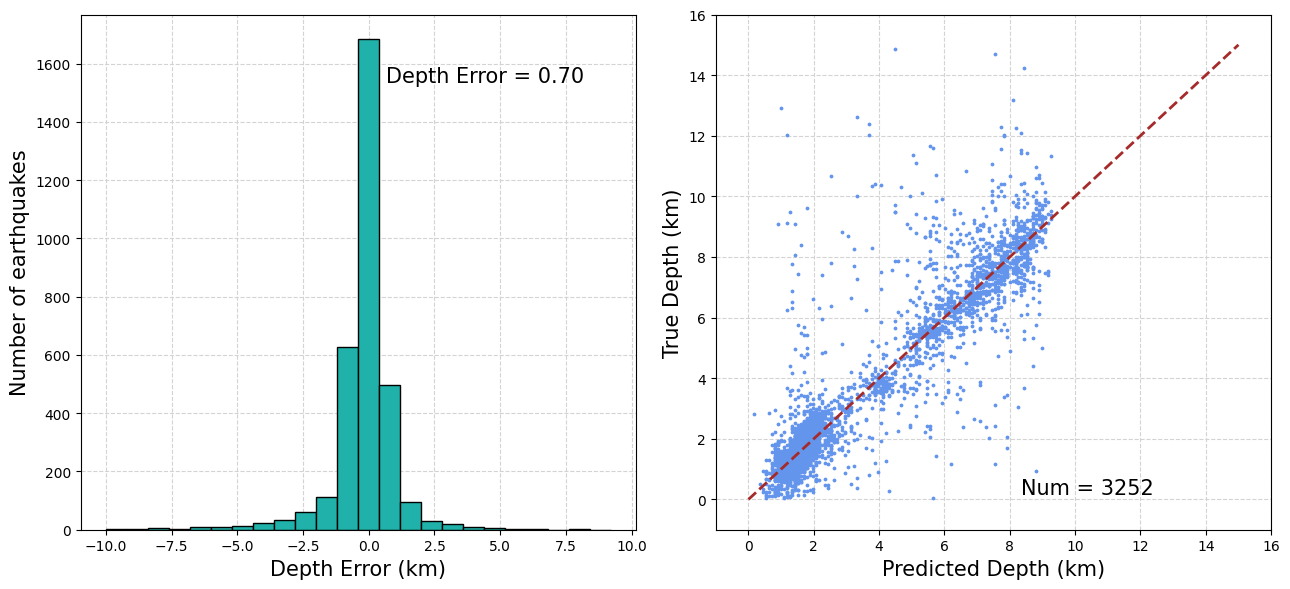

Average depth error: 0.70 km
Number of valid predictions: 3252


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import gaussian_kde


# 假设这些变量已经定义
num =6612

# 初始化 prediction_depth 数组
prediction_depth = np.zeros(num)

for i in range(num):
    a = test_result_CESI[i, :]
    a = np.reshape(a, (1, 256))
    maxValue = np.max(a)
    
    # 如果 maxValue 小于 0.5，跳过该预测
    if maxValue > 0.96:
        index = np.argmax(a)
        prediction_depth[i] = index * 0.08984375
    else:
        prediction_depth[i] = np.nan  # 或者设置为 None，表示无效预测



# 获取标签数据
label = label_xyz[0:0 + num, :]
label_depth = label[:, 2]
label_magnitude1 = label_magnitude[0:0 + num]

# 定义震级区间
min_magnitude = 0 # 最小震级
max_magnitude = 8 # 最大震级

min_snr = 5# 最小信噪比阈值
max_snr = 1000  # 最大信噪比阈值
### SNR 
station_ind = 3  ## station 3 is CESI's SNR
snr_station = snr_array[0:0+num,station_ind-1][:, np.newaxis]

# 过滤信噪比在指定区间的事件
valid_indices = np.where((label_magnitude1 >= min_magnitude) & (label_magnitude1 <= max_magnitude) & (snr_station >= min_snr) & (snr_station <= max_snr) )[0]

# 过滤掉预测值为 NaN 的数据
valid_indices = valid_indices[~np.isnan(prediction_depth[valid_indices])]  # 去除 NaN

prediction_depth = prediction_depth[valid_indices]
label_depth = label_depth[valid_indices]
label_magnitude1 = label_magnitude1[valid_indices]
snr = snr_station[valid_indices]  # 保留符合条件的 snr 数据

# 计算误差
error = np.sum(np.abs(prediction_depth - label_depth))
average_error = error / len(valid_indices) if len(valid_indices) > 0 else 0

# 创建深度数组和误差计算
Depth = np.vstack((prediction_depth, label_depth))
error1 = Depth[0, :] - Depth[1, :]

# 将误差四舍五入到小数点后一位
roundedErrors = np.round(error1, 1)

# 创建图形和设置背景颜色
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# 绘制误差直方图
ax1.hist(roundedErrors, bins=np.arange(-10, 10, 0.8), edgecolor='black', color=(32/255, 178/255, 170/255), zorder=2) 
ax1.set_xlabel('Depth Error (km)', fontsize=15)
ax1.set_ylabel('Number of earthquakes', fontsize=15)
ax1.grid(True, linestyle='--', color='lightgray', zorder=1)  # 添加虚线网格
ax1.text(0.55, 0.9, f'Depth Error = {average_error:.2f}', transform=ax1.transAxes, fontsize=15, verticalalignment='top')







# 绘制预测 vs 真实深度散点图
ax2.scatter(prediction_depth, label_depth, s=3, c='cornflowerblue', label='Predictions vs Truths', zorder=2)
ax2.plot([0, 15], [0, 15], color='brown', linestyle='--', linewidth=2, zorder=2)  # 添加 y=x 线
ax2.grid(True, linestyle='--', color='lightgray', zorder=1)  # 添加虚线网格
ax2.set_xlabel('Predicted Depth (km)', fontsize=15)
ax2.set_ylabel('True Depth (km)', fontsize=15)
ax2.text(0.55, 0.1, f'Num = {len(prediction_depth):.0f}', transform=ax2.transAxes, fontsize=15, verticalalignment='top')
ax2.set_xlim([-1, 16])
ax2.set_ylim([-1, 16])
# 调整布局
plt.tight_layout()
plt.show()





print(f'Average depth error: {average_error:.2f} km')
print(f'Number of valid predictions: {len(valid_indices)}')